## Task 7: Double DQN with Prioritized Experience Replay on LunarLander-v2
In this task, we implement a Deep Q-Network (DQN) with two improvements:
- **Double Q-learning** to reduce overestimation bias in action-value estimates.
- **Prioritized Experience Replay (PER)** to sample transitions based on TD error.
We apply this to the `LunarLander-v2` environment from OpenAI Gym, which has discrete actions and shaped rewards, making it ideal for value-based methods.

In [1]:
import gym
import numpy as np
import random
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Create environment with updated API
env = gym.make('LunarLander-v2') 
env.reset(seed=SEED)
env.action_space.seed(SEED)

# Observation and action sizes
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

print(f"State dimension: {state_dim}")
print(f"Number of actions: {n_actions}")

State dimension: 8
Number of actions: 4


### Q-Network Definition (Simple MLP)

In [2]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)

### Environment and Q-Network
We define our Q-network as a simple multi-layer perceptron with two hidden layers of 128 units each.
The output layer produces Q-values for all possible actions.
We also set the random seed for reproducibility and inspect the shape of the environment.

### Prioritized Experience Replay (PER)

In standard DQN, experiences are sampled uniformly from the replay buffer. This can be inefficient because many transitions are redundant or uninformative.

**Prioritized Experience Replay** addresses this by:
- Sampling transitions with probability proportional to their **temporal-difference (TD) error**,
- Storing and updating priorities to ensure **important experiences** (e.g., large errors) are replayed more often.

We implement **proportional prioritization**, where each transition is sampled with probability:

\[
P(i) = \frac{p_i^\alpha}{\sum_k p_k^\alpha}
\]

where \( p_i \) is the priority and \( \alpha \) determines the level of prioritization (α = 0 is uniform sampling).


In [3]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.alpha = alpha
        self.position = 0
        self.Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

    def push(self, state, action, reward, next_state, done):
        max_prio = self.priorities.max() if self.buffer else 1.0
        transition = self.Transition(state, action, reward, next_state, done)

        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.position] = transition

        self.priorities[self.position] = max_prio
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.position]

        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        # Importance-sampling weights
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()  # normalize

        batch = self.Transition(*zip(*samples))
        return batch, indices, torch.tensor(weights, dtype=torch.float32)

    def update_priorities(self, indices, priorities):
        for idx, prio in zip(indices, priorities):
            self.priorities[idx] = prio

We implement a prioritized buffer where transitions with high TD error are sampled more frequently.
The buffer stores a priority score for each transition and uses it to compute sampling probabilities.
We also calculate **importance sampling weights** to correct for this bias during gradient updates.

### DQN Agent with Double Q-learning

In standard DQN, we estimate the target Q-value using the maximum Q-value from the target network:

\[
y = r + \gamma \cdot \max_{a'} Q_{\text{target}}(s', a')
\]

This can lead to **overestimation bias**.  
In **Double Q-learning**, we use the main network to select the best action and the target network to evaluate it:

\[
y = r + \gamma \cdot Q_{\text{target}}(s', \arg\max_{a'} Q_{\text{main}}(s', a'))
\]

This decouples action selection and evaluation.


In [4]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, buffer, gamma=0.99, lr=1e-3, batch_size=64,
                 beta_start=0.4, use_per=True, use_double=True):
        self.q_net = QNetwork(state_dim, action_dim)
        self.target_net = QNetwork(state_dim, action_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.replay_buffer = buffer
        self.gamma = gamma
        self.batch_size = batch_size
        self.beta = beta_start
        self.loss_fn = nn.MSELoss()
        self.action_dim = action_dim
        self.step_count = 0
        self.use_per = use_per
        self.use_double = use_double

    def act(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.action_dim - 1)
        state = torch.from_numpy(np.array(state)).float().unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_net(state)
        return q_values.argmax().item()

    def update(self):
        if len(self.replay_buffer.buffer) < self.batch_size:
            return None

        self.beta = min(1.0, self.beta + 1e-4)

        if self.use_per:
            batch, indices, weights = self.replay_buffer.sample(self.batch_size, beta=self.beta)
        else:
            transitions = random.sample(self.replay_buffer.buffer, self.batch_size)
            Transition = self.replay_buffer.Transition
            batch = Transition(*zip(*transitions))
            weights = torch.ones(self.batch_size, 1, dtype=torch.float32)

        states = torch.tensor(np.array(batch.state), dtype=torch.float32)
        actions = torch.tensor(batch.action).unsqueeze(1)
        rewards = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(np.array(batch.next_state), dtype=torch.float32)
        dones = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1)
        weights = weights.unsqueeze(1)

        # Q values of current state-action pairs
        q_values = self.q_net(states).gather(1, actions)

        # Compute target values
        with torch.no_grad():
            if self.use_double:
                next_actions = self.q_net(next_states).argmax(1, keepdim=True)
                next_q = self.target_net(next_states).gather(1, next_actions)
            else:
                next_q = self.target_net(next_states).max(1, keepdim=True)[0]
            targets = rewards + self.gamma * (1 - dones) * next_q

        # TD error (for PER only)
        if self.use_per:
            td_errors = (q_values.detach() - targets.detach()).abs().cpu().numpy().flatten()
            self.replay_buffer.update_priorities(indices, td_errors + 1e-6)

        # Loss with importance sampling (or uniform weights)
        loss = (weights * (q_values - targets).pow(2)).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()


    def update_target_network(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

We now have a DQN agent that:
- Uses a main and target network for Double Q-learning,
- Samples and updates transitions based on their TD error (for PER),
- Applies importance sampling weights during updates,
- Slowly increases the `beta` parameter to correct PER bias over time.


### Training the Agent

We now train the Double DQN agent with Prioritized Experience Replay.
At each step:
1. The agent selects an action using ε-greedy exploration.
2. The environment returns the next state and reward.
3. The transition is stored in the PER buffer.
4. The agent updates its Q-network using sampled experiences.
5. Every `target_update_freq` steps, the target network is updated.


In [5]:
def train(agent, env, episodes=500, epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995, 
          target_update_freq=10, max_steps=1000):

    epsilon = epsilon_start
    episode_rewards = []
    losses = []

    for episode in range(episodes):
        result = env.reset()
        state = result[0] if isinstance(result, tuple) else result
        total_reward = 0

        for step in range(max_steps):
            action = agent.act(state, epsilon)
            step_result = env.step(action)
            if len(step_result) == 5:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_result


            agent.replay_buffer.push(state, action, reward, next_state, done)
            loss = agent.update()
            state = next_state
            total_reward += reward

            if done:
                break

        episode_rewards.append(total_reward)
        if loss is not None:
            losses.append(loss)

        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if episode % target_update_freq == 0:
            agent.update_target_network()

        if episode % 10 == 0:
            print(f"Episode {episode:4d} | Reward: {total_reward:.2f} | Epsilon: {epsilon:.3f}")

    return episode_rewards, losses

We now initialize the agent and replay buffer, then train the agent for 500 episodes.


In [6]:
# Initialize replay buffer and agent
# Replay buffer choice
buffer_per = PrioritizedReplayBuffer(100_000)
buffer_uniform = PrioritizedReplayBuffer(100_000)  # will ignore priorities

# Vanilla DQN (no PER, no Double Q)
agent_dqn = DQNAgent(state_dim, n_actions, buffer_uniform, use_per=False, use_double=False)

# DQN + Double Q-learning only
agent_double = DQNAgent(state_dim, n_actions, buffer_uniform, use_per=False, use_double=True)

# DQN + PER only
agent_per = DQNAgent(state_dim, n_actions, buffer_per, use_per=True, use_double=False)

# DQN + Double + PER
agent_full = DQNAgent(state_dim, n_actions, buffer_per, use_per=True, use_double=True)

### Helper Function to Train & Record Metrics

In [7]:
import time

def evaluate_agent(agent, label, episodes=500):
    print(f"Training: {label}")
    start = time.time()
    rewards, losses = train(agent, env, episodes=episodes)
    duration = time.time() - start
    avg_reward = np.mean(rewards[-100:])
    std_reward = np.std(rewards[-100:])
    return {
        'label': label,
        'rewards': rewards,
        'losses': losses,
        'avg_reward': avg_reward,
        'std_dev': std_reward,
        'duration_sec': duration
    }

### Run All Configurations

In [8]:
results = []

# Replay buffers
buffer_uniform_1 = PrioritizedReplayBuffer(100_000)
buffer_uniform_2 = PrioritizedReplayBuffer(100_000)
buffer_per_1 = PrioritizedReplayBuffer(100_000)
buffer_per_2 = PrioritizedReplayBuffer(100_000)

# Configurations
configs = [
    {"label": "Vanilla DQN", "per": False, "double": False, "buffer": buffer_uniform_1},
    {"label": "DQN + Double Q", "per": False, "double": True, "buffer": buffer_uniform_2},
    {"label": "DQN + PER", "per": True, "double": False, "buffer": buffer_per_1},
    {"label": "DQN + Double + PER", "per": True, "double": True, "buffer": buffer_per_2},
]

# Train and evaluate each config
for cfg in configs:
    agent = DQNAgent(state_dim, n_actions, cfg['buffer'], use_per=cfg['per'], use_double=cfg['double'])
    result = evaluate_agent(agent, cfg['label'], episodes=500)
    results.append(result)

Training: Vanilla DQN
Episode    0 | Reward: -225.61 | Epsilon: 0.995
Episode   10 | Reward: -90.47 | Epsilon: 0.946
Episode   20 | Reward: -393.43 | Epsilon: 0.900
Episode   30 | Reward: -14.35 | Epsilon: 0.856
Episode   40 | Reward: -96.28 | Epsilon: 0.814
Episode   50 | Reward: -115.53 | Epsilon: 0.774
Episode   60 | Reward: -157.32 | Epsilon: 0.737
Episode   70 | Reward: -181.34 | Epsilon: 0.701
Episode   80 | Reward: -184.01 | Epsilon: 0.666
Episode   90 | Reward: -45.91 | Epsilon: 0.634
Episode  100 | Reward: -149.66 | Epsilon: 0.603
Episode  110 | Reward: -130.41 | Epsilon: 0.573
Episode  120 | Reward: -374.32 | Epsilon: 0.545
Episode  130 | Reward: -62.96 | Epsilon: 0.519
Episode  140 | Reward: -4.84 | Epsilon: 0.493
Episode  150 | Reward: -44.99 | Epsilon: 0.469
Episode  160 | Reward: -30.43 | Epsilon: 0.446
Episode  170 | Reward: -56.66 | Epsilon: 0.424
Episode  180 | Reward: -28.40 | Epsilon: 0.404
Episode  190 | Reward: -118.39 | Epsilon: 0.384
Episode  200 | Reward: 46.64 

We now visualize the learning progress over time using a moving average of total rewards.

### Plot Smoothed Learning Curves

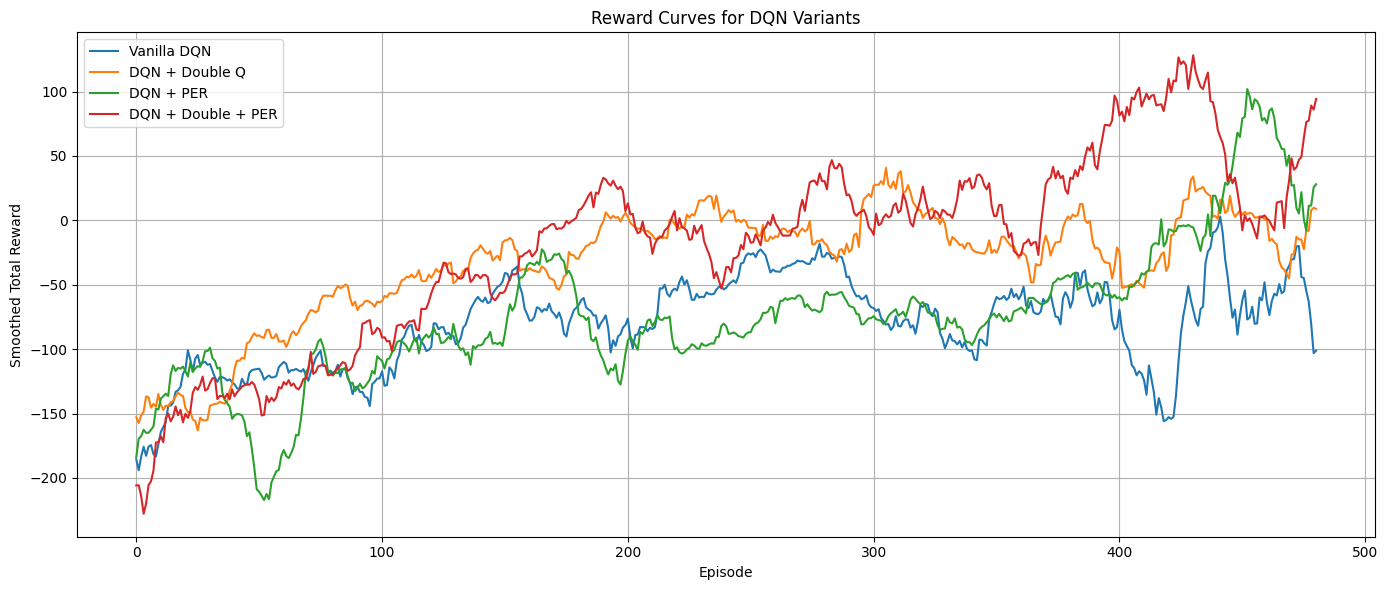

In [9]:
def moving_average(values, window=20):
    return np.convolve(values, np.ones(window)/window, mode='valid')

plt.figure(figsize=(14, 6))
for res in results:
    smoothed = moving_average(res['rewards'], window=20)
    plt.plot(smoothed, label=f"{res['label']}")
plt.title("Reward Curves for DQN Variants")
plt.xlabel("Episode")
plt.ylabel("Smoothed Total Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Tabulate Final Metrics

In [10]:
import pandas as pd

summary = pd.DataFrame([{
    'Label': r['label'],
    'Avg Reward (Last 100)': round(r['avg_reward'], 2),
    'Std Dev': round(r['std_dev'], 2),
    'Training Time (s)': round(r['duration_sec'], 2)
} for r in results])

summary

,Label,Avg Reward (Last 100),Std Dev,Training Time (s)
0,Vanilla DQN,-78.57,168.08,1130.60
1,DQN + Double Q,-9.93,117.21,1554.09
2,DQN + PER,9.92,135.86,2303.06
3,DQN + Double + PER,71.45,138.01,1632.62


## 🧪 Grid Search on DQN + Double Q + PER

To evaluate the effect of key hyperparameters, we perform a grid search on our best-performing DQN model with both **Double Q-learning** and **Prioritized Experience Replay**.

### 🔧 Hyperparameters investigated:
- **Learning Rate (lr)**: Controls how fast the Q-network updates — {1e-3, 5e-4, 1e-4}
- **Discount Factor (gamma)**: Importance of future rewards — {0.99, 0.95}
- **Epsilon Decay Rate (eps_decay)**: Controls exploration → exploitation — {0.99, 0.995}
- **Random Seed**: To test robustness across initializations — {42, 123}

Each configuration is trained for 500 episodes and evaluated on:
- Final average reward (last 100 episodes),
- Standard deviation,
- Training time (seconds).


In [12]:
from itertools import product
import time

# Hyperparameter grid
learning_rates = [1e-3, 5e-4, 1e-4]
gammas = [0.99, 0.95]
eps_decays = [0.99, 0.995]
seeds = [42, 123]

# Storage
grid_results = []

# Run grid search
for lr, gamma, eps_decay, seed in product(learning_rates, gammas, eps_decays, seeds):
    print(f"\n🔧 Running config: lr={lr}, gamma={gamma}, eps_decay={eps_decay}, seed={seed}")
    
    # Set random seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Create fresh env and buffer
    env = gym.make('LunarLander-v2')
    env.reset(seed=seed)
    env.action_space.seed(seed)
    buffer = PrioritizedReplayBuffer(100_000)

    # Create agent with DQN + Double + PER
    agent = DQNAgent(state_dim, n_actions, buffer, lr=lr, gamma=gamma, use_per=True, use_double=True)
    
    # Train and time it
    start_time = time.time()
    rewards, _ = train(agent, env, episodes=500, epsilon_decay=eps_decay)
    duration = time.time() - start_time

    # Evaluate
    avg_reward = np.mean(rewards[-100:])
    std_reward = np.std(rewards[-100:])
    
    grid_results.append({
        'lr': lr,
        'gamma': gamma,
        'eps_decay': eps_decay,
        'seed': seed,
        'avg_reward': avg_reward,
        'std_dev': std_reward,
        'duration_sec': duration
    })


🔧 Running config: lr=0.001, gamma=0.99, eps_decay=0.99, seed=42
Episode    0 | Reward: -206.09 | Epsilon: 0.990
Episode   10 | Reward: -79.64 | Epsilon: 0.895
Episode   20 | Reward: -327.10 | Epsilon: 0.810
Episode   30 | Reward: -268.75 | Epsilon: 0.732
Episode   40 | Reward: -54.60 | Epsilon: 0.662
Episode   50 | Reward: -167.18 | Epsilon: 0.599
Episode   60 | Reward: -197.47 | Epsilon: 0.542
Episode   70 | Reward: -38.22 | Epsilon: 0.490
Episode   80 | Reward: -27.50 | Epsilon: 0.443
Episode   90 | Reward: 21.02 | Epsilon: 0.401
Episode  100 | Reward: -10.03 | Epsilon: 0.362
Episode  110 | Reward: -0.81 | Epsilon: 0.328
Episode  120 | Reward: -11.33 | Epsilon: 0.296
Episode  130 | Reward: -44.74 | Epsilon: 0.268
Episode  140 | Reward: -19.86 | Epsilon: 0.242
Episode  150 | Reward: -41.91 | Epsilon: 0.219
Episode  160 | Reward: -70.94 | Epsilon: 0.198
Episode  170 | Reward: -43.66 | Epsilon: 0.179
Episode  180 | Reward: -98.84 | Epsilon: 0.162
Episode  190 | Reward: -47.74 | Epsilon

### 📈 Results Summary

We sort all tested configurations by average final reward (last 100 episodes) and compare them to identify the most effective combinations.

In [13]:
import pandas as pd
df_grid = pd.DataFrame(grid_results)
df_sorted = df_grid.sort_values(by="avg_reward", ascending=False).reset_index(drop=True)
df_sorted.head(10)

,lr,gamma,eps_decay,seed,avg_reward,std_dev,duration_sec
0,0.0005,0.99,0.990,42,140.703416,112.061120,3634.382368
1,0.0001,0.99,0.995,123,80.863015,107.208706,3513.435068
2,0.0010,0.99,0.990,123,71.288781,137.173763,3466.417691
3,0.0005,0.99,0.995,42,63.842453,109.502094,2999.978555
4,0.0001,0.99,0.995,42,50.166372,104.169694,3395.397919
5,0.0010,0.99,0.990,42,47.222137,140.701891,3288.428832
6,0.0010,0.99,0.995,123,17.472470,154.431482,2990.609757
7,0.0010,0.99,0.995,42,2.729524,99.865054,3013.518514
8,0.0001,0.95,0.995,42,-15.707685,100.380314,3302.664332
9,0.0001,0.99,0.990,42,-15.955816,38.007294,4292.460358


### Group and Average Across Seeds

In [14]:
import pandas as pd

# Convert list of dictionaries to DataFrame
df_grid = pd.DataFrame(grid_results)

# Group by hyperparameter combination
grouped = df_grid.groupby(['lr', 'gamma', 'eps_decay']).agg({
    'avg_reward': 'mean',
    'std_dev': 'mean',
    'duration_sec': 'mean'
}).reset_index()

# Sort by best average reward
grouped = grouped.sort_values(by='avg_reward', ascending=False).reset_index(drop=True)

# Display top results
grouped.head(10)

,lr,gamma,eps_decay,avg_reward,std_dev,duration_sec
0,0.0001,0.99,0.995,65.514693,105.689200,3454.416494
1,0.0010,0.99,0.990,59.255459,138.937827,3377.423262
2,0.0005,0.99,0.990,45.626943,100.523673,3811.938594
3,0.0005,0.99,0.995,16.644817,91.807266,3280.342795
4,0.0010,0.99,0.995,10.100997,127.148268,3002.064135
5,0.0001,0.99,0.990,-23.264571,40.931198,4313.485603
6,0.0001,0.95,0.995,-35.133470,79.215033,3300.800516
7,0.0010,0.95,0.995,-52.771130,66.708893,3082.342064
8,0.0001,0.95,0.990,-52.866462,63.318945,4307.575562
9,0.0005,0.95,0.990,-54.036470,67.344576,4188.730985


### 📊 Aggregated Results Across Seeds

To improve the robustness of our conclusions, we aggregate results across both tested random seeds. We compute the mean of:
- Final average reward (last 100 episodes),
- Standard deviation (stability),
- Training time (efficiency),

for each unique combination of:
- **Learning Rate**
- **Discount Factor (γ)**
- **Epsilon Decay Rate**

This allows us to identify strong general-performing hyperparameter settings, independent of randomness.
